# Analisador Audio Texto

Caderno para conversão e análise de audio.

Pré requisitos:

Instalar o ffmpeg para conversão de formatos de áudio.

Pode-se instalar pelo Homebrew por meio do comando: 
brew install ffmpeg ou sudo apt install ffmpeg (Ubunto)

Instalar a biblioteca vosk: pip install vosk

Baixar o modelo do vosk em português no site:
https://alphacephei.com/vosk/models
Arquivo: vosk-model-small-pt-0.3

Conversas de whatsapp: .opus
Gravacoes com iPhone:  .m4a
Musicas e outras: .mp3 .aac

In [56]:
# Importação das bibliotecas
import os

import subprocess
import sys

from vosk import Model, KaldiRecognizer, SetLogLevel

import json

import pandas as pd
import numpy as np

import IPython

import time

from tqdm.notebook import tqdm
import ipywidgets as widgets

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


In [26]:
# Ler vários formatos de arquivo de áudio de uma pasta.
# Acrescente '/' ao final do caminho da pasta

pasta = 'Audio/'

# Buscar na pasta apenas arquivo com a extencao .opus
lista_arquivos = []
todos_arquivos = os.listdir(pasta)
for arq in todos_arquivos:
    if arq.lower().endswith(".opus"):
        lista_arquivos.append(arq)

# Descomente a linha a seguir se quiser trazer todos os arquivos da pasta
#lista_arquivos = os.listdir(pasta) 
        
print(f"Quantidade de aquivos na pasta {pasta}: ", len(lista_arquivos))
#print(lista_arquivos)

Quantidade de aquivos na pasta Audio/:  35423


## 1. Leitura e Transcrição dos áudios

In [27]:
# Inicializar variáveis e modelo

SAMPLE_RATE = 16000

SetLogLevel(0)

model = Model('models/vosk-model-pt-fb-v0.1.1-20220516_2113') # modelo grande
#model = Model('models/vosk-model-small-pt-0.3') # modelo pequeno

rec = KaldiRecognizer(model, SAMPLE_RATE)
lista_transcricoes = []

# Ler cada arquivo e transcrever
inicio = time.time()

for arquivo in tqdm(lista_arquivos):    
    #print(f"Convertendo arquivo: {arquivo}")
    with subprocess.Popen(["ffmpeg", "-loglevel", "quiet", "-i",
                            pasta + arquivo,
                            "-ar", str(SAMPLE_RATE) , "-ac", "1", "-f", "s16le", "-"],
                            stdout=subprocess.PIPE) as process:
        transcricao = ' '
        dic_transcricao = {}
        #print(f"Arquivo convertido...Transcrevendo audio arquivo: {arquivo}")
  

        while True:
            data = process.stdout.read(4000)
            if len(data) == 0:
                break
            if rec.AcceptWaveform(data):
                dic_transcricao = json.loads(rec.Result())
                transcricao = transcricao + ' ' + dic_transcricao['text']

        dic_transcricao = json.loads(rec.FinalResult())
        transcricao = transcricao + ' ' + dic_transcricao['text']
        lista_transcricoes.append(transcricao)
        #print(f"Concluido: {arquivo}")

fim = time.time()

print("Tempo de Execução: ",(fim - inicio), " segundos")
print("Tempo de Execução: ",(fim - inicio)/60, " minutos")
print("Total de Arquivos Transcritos: ",len(lista_transcricoes) )

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from models/vosk-model-pt-fb-v0.1.1-20220516_2113/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from models/vosk-model-pt-fb-v0.1.1-20220516_2113/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:294) Loading words from models/vosk-model-pt-fb-v0.1.1-20220516_2113/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo models/vosk-model-pt-fb-v0.1.1-20220516_2113/gra

  0%|          | 0/35423 [00:00<?, ?it/s]

LOG (VoskAPI:RebuildRepository():determinize-lattice-pruned.cc:283) Rebuilding repository.
LOG (VoskAPI:RebuildRepository():determinize-lattice-pruned.cc:283) Rebuilding repository.
LOG (VoskAPI:RebuildRepository():determinize-lattice-pruned.cc:283) Rebuilding repository.
LOG (VoskAPI:RebuildRepository():determinize-lattice-pruned.cc:283) Rebuilding repository.
LOG (VoskAPI:RebuildRepository():determinize-lattice-pruned.cc:283) Rebuilding repository.
WARNING (VoskAPI:CheckMemoryUsage():determinize-lattice-pruned.cc:316) Did not reach requested beam in determinize-lattice: size exceeds maximum 50000000 bytes; (repo,arcs,elems) = (19540704,391744,30137640), after rebuilding, repo size was 16022432, effective beam was 4.39838 vs. requested beam 6


Tempo de Execução:  219450.2545018196  segundos
Tempo de Execução:  3657.5042416969936  minutos
Total de Arquivos Transcritos:  35423


In [28]:
# Cria um DataFrame com as transcrições
# O nome do arquivo é o índice do Dataframe, mas depois esse índice é convertido em coluna
# Acrescenta-se uma nova coluna com o caminho do arquivo
df_audio_transcricoes = []
df_audio_transcricoes =  pd.DataFrame(lista_transcricoes, index=lista_arquivos, columns=['transcricao'])
df_audio_transcricoes.head()

,transcricao
005663bf2c0b3309cb0a9d09136b5d91.opus,as contas estão sendo integradas à república...
03853a7a19f3f565c3309216c204df07.opus,um dia frank beleza entrou no centro cirúrgi...
03b1fd5dd2f540650d5089517fada3d1.opus,sem nota o alarme agora estou fazendo isso s...
04a1c5f531d5d35b61fa34912ec30795.opus,marconi na terça-feira que é o dia oficial d...
04fa7218ff281cab28cb02456aab6e85.opus,eu falei que ia só que não come média na seg...


# 2. Filtros

## 2.1 Filtros pelo nome do arquivo

In [31]:
# Realizar filtros pelo índice com nome do arquivo
arquivo_selecionado = '2650abded6ac6fff35a268693d983c24.opus'

print(df_audio_transcricoes['transcricao'].loc[arquivo_selecionado])


IPython.display.Audio(pasta + arquivo_selecionado)



  foi o roger disse que ligou provados e ele ligou pra mim pedir outra fã do fado era responsável pela malária passeio telefone tá bom beleza alheia


## 2.2 Filtro por Palavras-Chave

Realizar filtro por palavras-chaves em todos as transcrições a partir de uma planilhas com as palavras-chave.

A planilha com as palavras chave trata-se de um arquivo excel com apenas uma coluna nomeada de termo.

In [45]:
# Realizar filtro por palavras-chaves em todos as transcrições
lista_palavras_chaves = []
palavra_chave = []

# Lista de palavras chaves
#lista_palavras_chaves = ['jesus abençoado', 'família']

# Lista de palavras-chave a partir de um arquivo excel
df_palavras_chaves = pd.read_excel('palavras_chave.xlsx')
lista_palavras_chaves = list(df_palavras_chaves['termo'])

# Transforma a lista em uma string separada por | que representa o operador OR.
# Depois transforma a string para miníscula
palavra_chave = '|'.join(lista_palavras_chaves)
palavra_chave = palavra_chave.lower()

serie_resultado = df_audio_transcricoes['transcricao'].str.contains(palavra_chave)
serie_resultado

005663bf2c0b3309cb0a9d09136b5d91.opus    False
03853a7a19f3f565c3309216c204df07.opus    False
03b1fd5dd2f540650d5089517fada3d1.opus    False
04a1c5f531d5d35b61fa34912ec30795.opus    False
04fa7218ff281cab28cb02456aab6e85.opus    False
                                         ...  
PTT-20210804-WA0054.opus                 False
PTT-20210804-WA0088.opus                 False
PTT-20210804-WA0105.opus                 False
PTT-20210804-WA0106.opus                 False
PTT-20210804-WA0108.opus                  True
Name: transcricao, Length: 35423, dtype: bool

In [46]:
# Mostra as palavras chave utilizadas
palavra_chave

'gerir|transferência|depósito|contrato|dossiê|caixinha|acordo|dinheiro|porã|propina|café|cafezinho|prefeito|governador|deputado|patrão'

In [35]:
# Filtros da palavra chave
# Podemos mostrar tanto os audios em que APARECEM (True) as palavras chaves como NAO APARECEM (False)
# Filtra as colunas que APARECEM as palavras chave (True). Para False colocar ~ antes
df_filtrado = []
df_filtrado = df_audio_transcricoes[serie_resultado]
df_filtrado.head()

,transcricao
079b1eb67783811c178c6e311bba8e23.opus,você só precisa usar o seu falar nela pegar ...
10fd33c2d61573319f8a497c81eb0594.opus,pode ficar tranquilo conforme a gente começo...
254643910944c11606106e7cd5c16523.opus,botelho do arturo bem eduardo leia nosso jur...
582f20e93f4b771c125fef0843b06435.opus,até então pode tirar de um desses aí só com ...
62e14fae32d73053bc968dd2156c0bbc.opus,franco foi o de nelson me ligou é perguntand...


# 3. Nuvem de Palavras (wordcloud)

In [62]:
# Efetua download de pacotes da boblioteca nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andrelmr@cgu.local/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/andrelmr@cgu.local/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [103]:
# Ajusta o dataframe e junta todo o conteudo do campo transcricao em uma unica string sem espaços duplos
df_nuvem_filtrado = df_filtrado.rename_axis('arquivo').reset_index()
string_palavras = df_nuvem_filtrado['transcricao'].to_string()
string_palavras = ' '.join(string_palavras.split())
#print(string_palavras)

In [102]:
# Remove as stop words
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize

stopwords = set(nltk.corpus.stopwords.words('portuguese'))

palavras_tokenized = nltk.word_tokenize(string_palavras, language='portuguese')
#palavras = nltk.sent_tokenize(string_palavras, language='portuguese')
#palavras = nltk.wordpunct_tokenize(string_palavras)

#palavras = [palavras.lower() for palavras in palavras]

palavras_para_nuvem = ' '

for palavra in palavras_tokenized:
    if not(palavra in stopwords):
        palavras_para_nuvem = palavras_para_nuvem + ' ' + palavra

#print(palavras_para_nuvem)


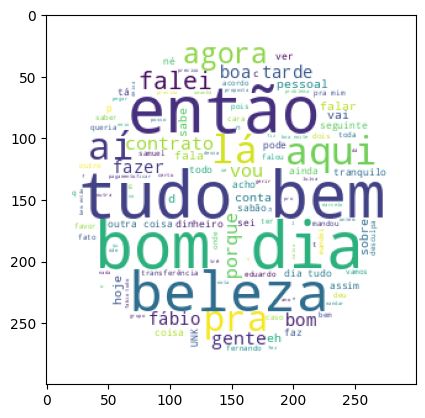

In [100]:

# Plota a nuvem de palavras e grava em um arquivo de imagem
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="white", repeat=True, mask=mask)

wc.generate(palavras_para_nuvem)
wc.to_file("Saida/wordcloud/laudo_XXX_20XX_item_XX.png")
plt.imshow(wc) 



# 4. Exportação para Excel

In [47]:
# Prepara os Dataframes para exportação, transformando os índices em colunas e acrescentando o caminho do arquivo

df_saida_audio_transcricoes = []
df_saida_filtrado = []

df_saida_audio_transcricoes = df_audio_transcricoes.rename_axis('arquivo').reset_index()
df_saida_audio_transcricoes['caminho'] = pasta + df_saida_audio_transcricoes['arquivo']

if len(df_filtrado) == 0:
    df_saida_filtrado = pd.DataFrame({'mensagem' : ['Não econtrou ocorrências nas palavras chave'] })
else:
    df_saida_filtrado = df_filtrado.rename_axis('arquivo').reset_index()
    df_saida_filtrado['caminho'] = pasta + df_saida_filtrado['arquivo']

# Exporta os Dataframes para excel

saida = 'Saida/excel/laudo_XXX_20XX_item_XX.xlsx'

with pd.ExcelWriter(saida) as writer:
    df_saida_audio_transcricoes.to_excel(writer, index=False, sheet_name='audios_transcritos')
    df_saida_filtrado.to_excel(writer, index=False, sheet_name='audios_filtrados')
    df_palavras_chaves.to_excel(writer, index=False, sheet_name='palavras_chave_utilizadas')

print(f"Arquivo gerado: {saida}")

Arquivo gerado: Saida/excel/audios_transcritos.xlsx
